<a href="https://colab.research.google.com/github/Leinadh/PeruvianImageGenerator/blob/master/xgan_baseline_pytorch_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGAN: Unsupervised Image-to-Image Translation for Many-to-Many Mappings

Implementation of XGAN model for automatic cartoon generation from real faces. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os 

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader

from tqdm import tqdm
from PIL import Image

In [4]:
### hyperparameters ###
#latent_dims = 2
num_epochs = 20
batch_size = 32
learning_rate = 1e-3
image_size = 64
#variational_beta = 1
use_gpu = True
workers = 4

## Preprocessing images - faces

In [5]:
!unzip '/content/drive/My Drive/Made with ML/datasets/faces_wo_bg.zip'

Archive:  /content/drive/My Drive/Made with ML/datasets/faces_wo_bg.zip
   creating: content/images/
   creating: content/images/faces_people_wo_bg/
  inflating: content/images/faces_people_wo_bg/Kristina_Anapau_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Ray_Winstone_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Michael_Ealy_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/David_Niven_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Ashley_Jensen_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Tim_Minchin_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/William_Fichtner_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Katrina_Bowden_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Maria_de_Medeiros_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Mark_Feuerstein_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Jessie_J_0_wo_bg.jpg  
  inflating: content/imag

In [6]:
import cv2
import helper

(297, 237, 3)


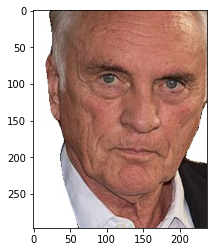

In [7]:
path_images = '/content/content/images/faces_people_wo_bg/'

img = cv2.imread(path_images + 'Terence_Stamp_0_wo_bg.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(img.shape)
plt.imshow(img)
plt.show()

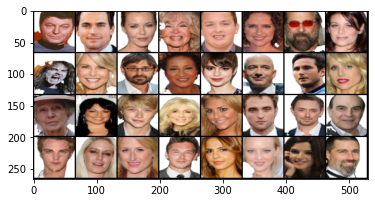

In [54]:
path_images = '/content/content/images/'

transform = transforms.Compose([
                transforms.Resize((image_size,image_size)) ,
                transforms.ToTensor(),
                # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                ])

dataloader_images = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(path_images, transform=transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers = workers)

dataiter = iter(dataloader_images)
images_faces = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_faces[0]).permute(1, 2, 0)[:,:,[2,1,0]])

# Preprocessing cartoons

In [9]:
!mkdir cartoon_images

In [10]:
!tar zxvf '/content/drive/My Drive/Made with ML/datasets/cartoonset10k.tgz'

Se han truncado las últimas 5000 líneas del flujo de salida.
cartoonset10k/cs11130198548099864740.png
cartoonset10k/cs11130522928710913906.csv
cartoonset10k/cs11130522928710913906.png
cartoonset10k/cs11130692035407747496.csv
cartoonset10k/cs11130692035407747496.png
cartoonset10k/cs1113080672465802980.csv
cartoonset10k/cs1113080672465802980.png
cartoonset10k/cs11131138722323947780.csv
cartoonset10k/cs11131138722323947780.png
cartoonset10k/cs1113121412202668922.csv
cartoonset10k/cs1113121412202668922.png
cartoonset10k/cs11131333133753359573.csv
cartoonset10k/cs11131333133753359573.png
cartoonset10k/cs1113143340294813643.csv
cartoonset10k/cs1113143340294813643.png
cartoonset10k/cs11131732994961040179.csv
cartoonset10k/cs11131732994961040179.png
cartoonset10k/cs1113191746674328122.csv
cartoonset10k/cs1113191746674328122.png
cartoonset10k/cs11131958805482037869.csv
cartoonset10k/cs11131958805482037869.png
cartoonset10k/cs1113266829786440678.csv
cartoonset10k/cs1113266829786440678.png
cartoo

In [11]:
%cd cartoonset10k/
!rm *.csv
%cd ..

/content/cartoonset10k
/content


In [12]:
!mv cartoonset10k cartoon_images

In [13]:
!pwd

/content


(500, 500, 3)


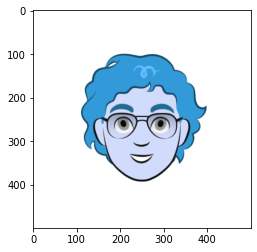

In [14]:
path_cartoons = '/content/cartoon_images/cartoonset10k/'

img = cv2.imread(path_cartoons + 'cs1048486361028912.png')
#img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(img.shape)
plt.imshow(img)
plt.show()

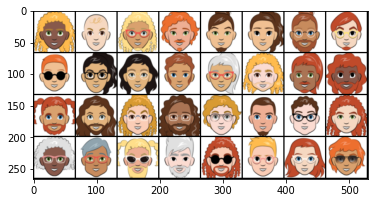

In [78]:
path_cartoons = '/content/cartoon_images/'

transform = transforms.Compose([
                transforms.CenterCrop(300),
                transforms.Resize((image_size,image_size)) ,
                transforms.ToTensor(),
                # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                ])

dataloader_cartoons = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(path_cartoons, transform=transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers = workers)

dataiter = iter(dataloader_cartoons)
images_cartoon = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_cartoon[0]).permute(1, 2, 0))

## XGAN Model

### Classes

In [28]:
class E1(nn.Module):
  def __init__(self):
    super(E1, self).__init__()
    #c=capacity
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1) # out: 32 x 32 x 32
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1) #out: 16 x 16 x 64

  def forward(self, x):
    x = F.relu(self.conv1(x)) #try selu
    x = F.relu(self.conv2(x))
    return x  

class E2(nn.Module):
  def __init__(self):
    super(E2, self).__init__()
    #c=capacity
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1) # out: 32 x 32 x 32
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1) #out: 16 x 16 x 64

  def forward(self, x):
    x = F.relu(self.conv1(x)) #try selu
    x = F.relu(self.conv2(x))
    return x

class Eshared(nn.Module):
  def __init__(self):
    super(Eshared, self).__init__()
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features = 4*4*256, out_features = 1024)
    self.fc2 = nn.Linear(in_features = 1024, out_features = 1024)
  
  def forward(self,x):
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    
    return x
    

class Dshared(nn.Module):
  def __init__(self):
    super(Dshared, self).__init__()
    #c = capacity
    self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2)
    self.deconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
  
  def forward(self,x):
    x = x.view(-1,1024,1,1)
    x = F.relu(self.deconv1(x))
    x = F.relu(self.deconv2(x))
    return x

class D1(nn.Module):
  def __init__(self):
    super(D1, self).__init__()
    #c = capacity
    self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
    self.deconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
    self.deconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2)
  
  def forward(self,x):
    x = F.relu(self.deconv3(x))
    x = F.relu(self.deconv4(x))
    x = F.relu(self.deconv5(x))
    return x

class D2(nn.Module):
  def __init__(self):
    super(D2, self).__init__()
    #c = capacity
    self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
    self.deconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
    self.deconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2)
  
  def forward(self,x):
    x = F.relu(self.deconv3(x))
    x = F.relu(self.deconv4(x))
    x = F.relu(self.deconv5(x)) 
    return x

class Cdann(nn.Module):
  def __init__(self):
    super(Cdann, self).__init__()
    self.fc1 = nn.Linear(in_features = 1024, out_features = 512)
    self.fc2 = nn.Linear(in_features = 512 , out_features = 256)
    self.fc3 = nn.Linear(in_features = 256 , out_features = 64)
    self.fc4 = nn.Linear(in_features = 64, out_features = 1)

  def forward(self, x):
    #x = torch.flatten(x) #check dimensions
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))

    return x

class Xgan(nn.Module):               ##### only double autoencoder, no Ldann, Lsem, Lteach, L...
  def __init__(self):
    super(Xgan, self).__init__()
    self.e1 = E1()
    self.e2 = E2()
    self.eshared = Eshared()
    self.d1 = D1()
    self.d2 = D2()
    self.dshared = Dshared()
    
  def forward(self,cartoon, face):
    x1 = self.e1(face)
    x2 = self.e2(cartoon)
    ########   to be defined  ########
    x_joint = torch.tensor([0]) 
    x_shared = self.eshared(x_joint)
    x_dshared = self.dshared(x_shared)
    x_face = self.d1(x_shared)
    x_cartoon = self.d2(x_shared)
    return x_face, x_cartoon

### Loss functions

In [17]:
def Lrec_1(image_rec, image_orig):

  image_rec_r = image_rec.view(-1,64*64*3)
  image_orig_r = image_orig.view(-1,64*64*3)
  #mse
  rec_loss = torch.norm(image_rec_r - image_orig_r, 2)
  
  rec_loss = torch.mean(rec_loss)

  return rec_loss


## Trainning

In [56]:
e1 = E1()
e2 = E2()
e_shared = Eshared()
d_shared = Dshared()
d1 = D1()
d2 = D2()

classifier_encoders = Cdann()

In [57]:
listRec1 = list(e1.parameters()) + list(e_shared.parameters()) + list(d_shared.parameters()) + list(d1.parameters())
optimizerRec1 = torch.optim.Adam(listRec1,lr=learning_rate)

listRec2 = list(e2.parameters()) + list(e_shared.parameters()) + list(d_shared.parameters()) + list(d2.parameters())
optimizerRec2 = torch.optim.Adam(listRec2,lr=learning_rate)


listEncoder1 = list(e1.parameters()) + list(e_shared.parameters())
optimizerEnc1 = torch.optim.Adam(listEncoder1,lr=learning_rate)

listEncoder2 = list(e2.parameters()) + list(e_shared.parameters())
optimizerEnc2 = torch.optim.Adam(listEncoder2,lr=learning_rate)

optimizerCdann = torch.optim.Adam(classifier_encoders.parameters(), lr = learning_rate)

In [58]:
criterion_bc = nn.BCELoss()

In [59]:
torch.cuda.is_available()

True

In [60]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

In [61]:
e1.to(device)
e2.to(device)
e_shared.to(device)
d_shared.to(device)
d1.to(device)
d2.to(device)
classifier_encoders.to(device)

criterion_bc.to(device) # it's a good habit

BCELoss()

In [90]:
train_loss_rec1 = []
train_loss_rec2 = []
train_loss_cdan = []
for epoch in range(num_epochs):
  for image_batch,cartoon_batch in zip(dataloader_images, dataloader_cartoons):
    image_batch,_ = image_batch
    image_batch = Variable(image_batch.type(torch.Tensor))
    class_image = Variable(torch.ones(image_batch.size(0)))
    image_batch = image_batch.to(device)
    class_image = class_image.to(device)
    
    cartoon_batch,_ = cartoon_batch
    cartoon_batch = Variable(cartoon_batch.type(torch.Tensor))
    class_cartoon = Variable(torch.zeros(cartoon_batch.size(0)))
    cartoon_batch = cartoon_batch.to(device)
    class_cartoon = class_cartoon.to(device)
    
    #reconstruction image
    e1.zero_grad()
    e2.zero_grad()
    e_shared.zero_grad()
    d_shared.zero_grad()
    d1.zero_grad()
    d2.zero_grad()

    image_enc1 = e1(image_batch)
    image_encoder = e_shared(image_enc1)
    image_decoder = d_shared(image_encoder)
    image_rec = d1(image_decoder)

    cartoon_enc2 = e2(cartoon_batch)
    cartoon_encoder = e_shared(cartoon_enc2)
    cartoon_decoder = d_shared(cartoon_encoder)
    cartoon_rec = d2(cartoon_decoder)

    loss_rec1 = Lrec_1(image_batch, image_rec)
    loss_rec2 = Lrec_1(cartoon_batch, cartoon_rec)

    loss_rec1.backward()
    loss_rec2.backward()

    optimizerRec1.step()
    optimizerRec2.step()


    #classify encoders optimizar parametros del clasificador
    classifier_encoders.zero_grad()
    e1.zero_grad()
    e2.zero_grad()
    e_shared.zero_grad()

    image_enc1 = e1(image_batch).detach()
    image_encoder = e_shared(image_enc1).detach()

    cartoon_enc2 = e2(cartoon_batch).detach()
    cartoon_encoder = e_shared(cartoon_enc2).detach()


    class_enc1 = classifier_encoders(image_encoder)
    class_enc2 = classifier_encoders(cartoon_encoder)

    error_class_image = criterion_bc(class_enc1.squeeze(),class_image)
    error_class_image.backward()
    error_class_cartoon = criterion_bc(class_enc2.squeeze(),class_cartoon)
    error_class_cartoon.backward()

    error_classifier_encoders = error_class_image + error_class_cartoon
    optimizerCdann.step()


    #optimizar parametros del encoder (e1,e2 y eshared)
    e1.zero_grad()
    e2.zero_grad()
    e_shared.zero_grad()

    image_enc1 = e1(image_batch)
    image_encoder = e_shared(image_enc1)

    cartoon_enc2 = e2(cartoon_batch)
    cartoon_encoder = e_shared(cartoon_enc2)

    class_enc1 = classifier_encoders(image_encoder)
    class_enc2 = classifier_encoders(cartoon_encoder)

    class_image.data.fill_(0)
    class_cartoon.data.fill_(1)  

    error_class_image= criterion_bc(class_enc1.squeeze(),class_image)
    error_class_image.backward()
    error_class_cartoon= criterion_bc(class_enc2.squeeze(),class_cartoon)
    error_class_cartoon.backward()
    
    optimizerEnc1.step()
    optimizerEnc2.step()


  train_loss_rec1.append(loss_rec1.item())
  train_loss_rec2.append(loss_rec2.item())
  train_loss_cdan.append(error_classifier_encoders.item())
  print('Epoch [{}/{}], Loss rec1: {:.4f}'.format(epoch+1, num_epochs, loss_rec1.item()))
  print('Epoch [{}/{}], Loss rec2: {:.4f}'.format(epoch+1, num_epochs, loss_rec2.item()))
  print('Epoch [{}/{}], Loss classifier: {:.4f}'.format(epoch+1, num_epochs, error_classifier_encoders.item()))     


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20], Loss rec1: 80.4555
Epoch [1/20], Loss rec2: 113.9015
Epoch [1/20], Loss classifier: 1.4371
Epoch [2/20], Loss rec1: 85.5111
Epoch [2/20], Loss rec2: 131.5925
Epoch [2/20], Loss classifier: 1.4797
Epoch [3/20], Loss rec1: 69.0369
Epoch [3/20], Loss rec2: 128.1361
Epoch [3/20], Loss classifier: 1.4383
Epoch [4/20], Loss rec1: 72.6034
Epoch [4/20], Loss rec2: 119.7843
Epoch [4/20], Loss classifier: 1.3074
Epoch [5/20], Loss rec1: 94.5222
Epoch [5/20], Loss rec2: 167.1823
Epoch [5/20], Loss classifier: 2.0564
Epoch [6/20], Loss rec1: 142.8481
Epoch [6/20], Loss rec2: 127.6058
Epoch [6/20], Loss classifier: 1.5344
Epoch [7/20], Loss rec1: 83.2959
Epoch [7/20], Loss rec2: 113.3332
Epoch [7/20], Loss classifier: 1.4765
Epoch [8/20], Loss rec1: 80.2686
Epoch [8/20], Loss rec2: 155.5230
Epoch [8/20], Loss classifier: 1.8300
Epoch [9/20], Loss rec1: 75.7443
Epoch [9/20], Loss rec2: 150.7091
Epoch [9/20], Loss classifier: 1.4008
Epoch [10/20], Loss rec1: 72.5245
Epoch [10/20], Loss 

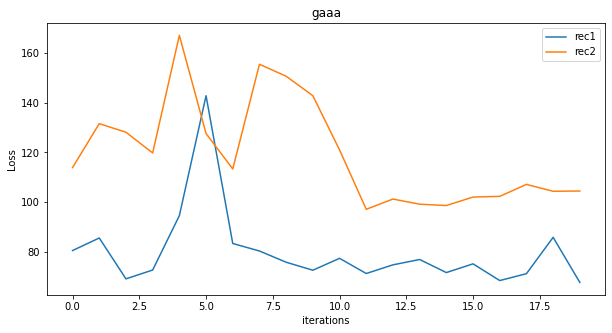

In [91]:
plt.figure(figsize=(10,5))
plt.title("gaaa")
plt.plot(train_loss_rec1,label="rec1")
plt.plot(train_loss_rec2,label="rec2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

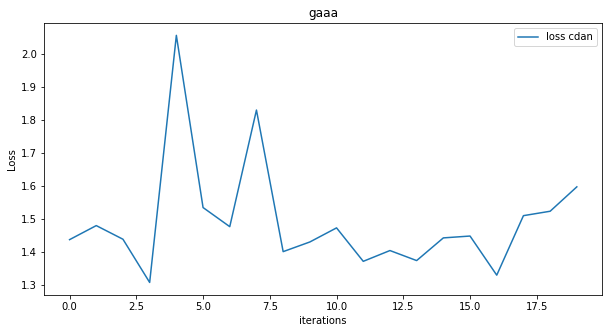

In [92]:
plt.figure(figsize=(10,5))
plt.title("gaaa")
plt.plot(train_loss_cdan,label="loss cdan")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

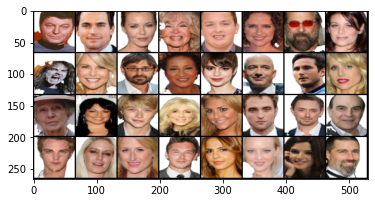

In [93]:
plt.imshow(torchvision.utils.make_grid(images_faces[0]).permute(1, 2, 0)[:,:,[2,1,0]])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


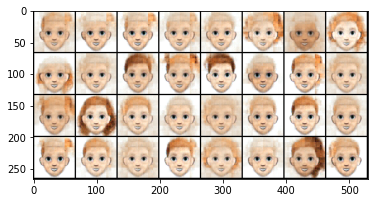

In [94]:
with torch.no_grad():
    output = e1(images_faces[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)
  
# grid4 = torchvision.utils.make_grid(output.cpu(), nrow=1)
# plt.figure(figsize=(12, 12))
# plt.imshow(grid4.permute(1, 2, 0))



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


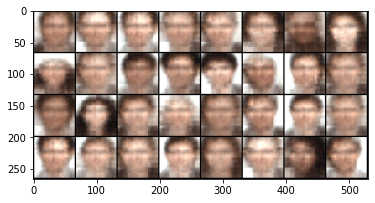

In [95]:
with torch.no_grad():
    output = e1(images_faces[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d1(output)
  
# grid4 = torchvision.utils.make_grid(output.cpu(), nrow=1)
# plt.figure(figsize=(12, 12))
# plt.imshow(grid4.permute(1, 2, 0))



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0)[:,:,[2,1,0]])
plt.show()

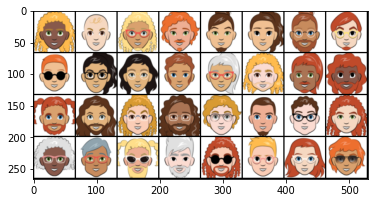

In [96]:
plt.imshow(torchvision.utils.make_grid(images_cartoon[0]).permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


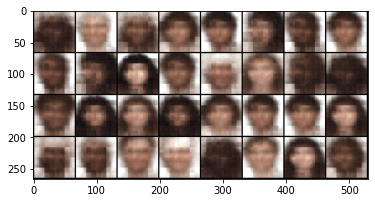

In [97]:
with torch.no_grad():
    output = e2(images_cartoon[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d1(output)
  
# grid4 = torchvision.utils.make_grid(output.cpu(), nrow=1)
# plt.figure(figsize=(12, 12))
# plt.imshow(grid4.permute(1, 2, 0))



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0)[:,:,[2,1,0]])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


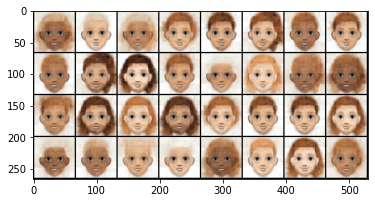

In [98]:
with torch.no_grad():
    output = e2(images_cartoon[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)
  
# grid4 = torchvision.utils.make_grid(output.cpu(), nrow=1)
# plt.figure(figsize=(12, 12))
# plt.imshow(grid4.permute(1, 2, 0))



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()